In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy
import scorecardpy as sc
%matplotlib inline 

In [ ]:
app = pd.read_csv('./data/data_application_sampled.csv', low_memory = False) 
app.columns = [
    "creditScore",
    "firstPaymentDate",
    "firstTimeHomebuyerFlag",
    "maturityDate",
    "areaCode",  # Metropolitan Division or MSA Code
    "mortgageInsurancePct",
    "numberOfUnits",
    "occupancyStatus",
    "originalCombinedLoanToValue",
    "originalDebtToIncomeRatio",
    "originalUpb",
    "originalLoanToValue",
    "originalInterestRate",
    "channel",
    "prepaymentPenaltyMortgageFlag",
    "amortizationType",
    "propertyState",
    "propertyType",
    "postalCode",
    "loanSequenceNumber",
    "loanPurpose",
    "originalLoanTerm",
    "numberOfBorrowers",
    "sellerName",
    "servicerName",
    "superConformingFlag", # col 26
    "preReliefRefinanceLoanSeqNumber",
    "programIndicator",  # col 28
    "reliefRefinanceIndicator",
    "propertyValuationMethod",
    "interestOnlyIndicator",
    "miCancellationIndicator" # 32 columns in total
    ]

perf = pd.read_csv('./data/data_performance_sampled.csv', low_memory = False)
perf.columns = [
   "loanSequenceNumber",
   "monthlyReportingPeriod",
   "currentActualUpb",
   "currentLoanDelinquencyStatus",
   "loanAge",
   "remainingMonthsToLegalMaturity",
   "defectSettlementDate",
   "modificationFlag",
   "zeroBalanceCode",
   "zeroBalanceEffectiveDate",
   "currentInterestRate",
   "currentNonInterestBearingUpb",
   "dueDateOfLastPaidInstallment",
   "miRecoveries",
   "netSaleProceeds",
   "nonMiRecoveries",
   "totalExpenses",
   "legalCosts",
   "maintenanceAndPreservationCosts",
   "taxesAndInsurance",
   "miscellaneousExpenses",
   "actualLossCalculation",
   "cumulativeModificationCost",
   "stepModificationFlag",
   "paymentDeferral",
   "estimatedLoanToValue",
   "zeroBalanceRemovalUpb",
   "delinquentAccruedInterest",
   "delinquencyDueToDisaster",
   "borrowerAssistanceStatusCode",
   "currentMonthModificationCost",
   "interestBearingUpb"
   ]

#### create target variable

In [3]:
# define default cases 
perf['currentLoanDelinquencyStatus'] = perf['currentLoanDelinquencyStatus'].astype(str)
bad = list(np.unique(perf.currentLoanDelinquencyStatus))
for i in range(3):
    bad.remove(str(i))  # remove '0', '1', '2'. they paid within 90 days

In [ ]:
perf = perf.sort_values(['loanSequenceNumber', 'monthlyReportingPeriod'])

In [7]:
perf['target'] = np.nan

for loan_id, group in perf.groupby('loanSequenceNumber'):
    months = group['monthlyReportingPeriod']   # get all the months value for a given loan
    statuses = group['currentLoanDelinquencyStatus']   # get all the statuses
    zerobalance_code = group['zeroBalanceCode'].iloc[-1]
    
    for i in range(len(group)):
        curr = months.iloc[i]
        status_window = statuses[(months > curr) & (months <= curr+100)]  # 12 month after the current month
        
        if status_window.str.contains('|'.join(bad)).any():
            perf.at[group.index[i], 'target'] = 1
        else:
            if len(status_window) == 12:
                perf.at[group.index[i], 'target'] = 0
            else:   # if the observation window is < 12, use zero balance code
                if zerobalance_code == 1:   # ==1 means prepaid 
                    perf.at[group.index[i], 'target'] = 0
                if pd.notna(zerobalance_code) and zerobalance_code != 1:
                    perf.at[group.index[i], 'target'] = 1

#### feature engineering

In [8]:
# creating behavorial variables from performance dataset

# 1 UPB percentage change
perf['upb_prev'] = perf.groupby('loanSequenceNumber')['currentActualUpb'].shift(1)
perf['upbPctChange'] = (perf['currentActualUpb'] - perf['upb_prev']) / perf['upb_prev']

# 2 Count of non-payments in past 3 months
perf['nonpayment'] = perf['upbPctChange'].apply(lambda x: 1 if x >=0 else 0)
perf['nonPmts_3m'] = (
    perf.groupby('loanSequenceNumber')['nonpayment']
    .rolling(window=3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

# 3 whether a person has defaulted due to a disaster
def has_past_disaster_flag(x):
    # Tracks if any earlier row has a 'Y' before current one
    history = []
    seen_y = False
    for val in x:
        history.append('Y' if seen_y else 'N')
        if val == 'Y':
            seen_y = True
    return history

perf['delinquencyDueToDisaster_hist'] = (
    perf.groupby('loanSequenceNumber')['delinquencyDueToDisaster']
    .transform(has_past_disaster_flag)
)


In [9]:
# 4 the ratio of interestBearingUpb to currentActualUpb
perf['interestBearingUpb_ratio'] = np.where(
    (perf['interestBearingUpb'] == 0) & (perf['currentActualUpb'] == 0),
    0,
    perf['interestBearingUpb'] / perf['currentActualUpb'])

In [10]:
# drop temporary variables
perf= perf.drop(columns=['upb_prev', 'nonpayment'])

In [11]:
# visulize
perf.loc[perf.loanSequenceNumber == 'F14Q10051996',
          ['monthlyReportingPeriod', 'currentLoanDelinquencyStatus', 'zeroBalanceCode',
           'delinquencyDueToDisaster', 'delinquencyDueToDisaster_hist',
           'upbPctChange', 'nonPmts_3m', 'interestBearingUpb_ratio']]

,monthlyReportingPeriod,currentLoanDelinquencyStatus,zeroBalanceCode,delinquencyDueToDisaster,delinquencyDueToDisaster_hist,upbPctChange,nonPmts_3m,interestBearingUpb_ratio
1940,202101,7,NaN,Y,N,NaN,0.0,1.0
1941,202102,8,NaN,Y,Y,0.000000,1.0,1.0
1942,202103,8,NaN,NaN,Y,-0.002249,1.0,1.0
1943,202104,8,NaN,Y,Y,-0.002263,1.0,1.0
1944,202105,8,NaN,Y,Y,-0.002277,0.0,1.0
1945,202106,9,NaN,Y,Y,0.000000,1.0,1.0
1946,202107,10,NaN,Y,Y,0.000000,2.0,1.0
1947,202108,10,NaN,NaN,Y,-0.002291,2.0,1.0
1948,202109,11,NaN,Y,Y,0.000000,2.0,1.0
1949,202110,12,NaN,Y,Y,0.000000,2.0,1.0


$target_{it}$ = 1 means defaulter at $t$ for loan $i$

#### merge two datasets, split the full dataset

In [ ]:
full = pd.merge(perf, app, on='loanSequenceNumber', how='left')
full = full[full['target'].notna()]
full.to_pickle('./data/010_full.pkl')

In [13]:
full = pd.read_pickle('full.pkl')
oot = full[full.monthlyReportingPeriod == 202406]
other = full[full.monthlyReportingPeriod != 202406]

In [14]:
train, test = sc.split_df(other,
                          y='target',
                          ratio=0.7,
                          seed=251417829).values()

In [ ]:
# check the distribution of the response
print(train['target'].mean(), test['target'].mean())

0.04442943802220442 0.04442865803339894


In [17]:
train.to_pickle('./data/010_train.pkl')
test.to_pickle('./data/010_test.pkl')

#### missing values, remove redundant variables
these are for predicting PD using logistic regression, not data cleaning for the whole task (will do cleaning for LGD modeling separately)

In [18]:
train = pd.read_pickle('./data/010_train.pkl')

features originally from application dataset

In [20]:
# missing values impute using median
train['creditScore'] = train['creditScore'].replace(to_replace=9999,
                                                    value= train['creditScore'].median())

train['originalDebtToIncomeRatio'] = train['originalDebtToIncomeRatio'].replace(to_replace = 999, 
                                        value = train['originalDebtToIncomeRatio'].median())

In [21]:
# due to high mutual information value w/ postalCode
train = train.drop(columns='areaCode') 

# due to 0.98 correlation with originalLoanToValue
train = train.drop(columns='originalCombinedLoanToValue') 

# not useful
train = train.drop(columns=['sellerName', 'servicerName'])

# superConformingFlag
# according to the user guide, nulls are actully Not Super Conforming
train['superConformingFlag'] = train['superConformingFlag'].fillna('N')

# this is a seq number which has no meaning & 98% are missing, so drop it
train.drop(columns='preReliefRefinanceLoanSeqNumber', inplace=True)

# nulls are actually 'N', as opposed to 'Y' for this feature
train['reliefRefinanceIndicator'] = train['reliefRefinanceIndicator'].fillna('N') 

In [22]:
# miscallenous
# '9' means Not available or not applicable, replace for readability
train['programIndicator'] = train['programIndicator'].replace(to_replace='9', value='NA')
train['propertyValuationMethod'] = train['propertyValuationMethod'].replace(9, 'NA')

features from performance dataset

In [ ]:
train = train.drop(columns=['zeroBalanceCode', 'zeroBalanceEffectiveDate'])  # have been used to create the target, see document

In [ ]:
# nulls are a category by themselves, thus replace with values.
train['modificationFlag'] = train['modificationFlag'].fillna('N')

train['stepModificationFlag'] = train['stepModificationFlag'].fillna('NotModified')

train['paymentDeferral'] = train['paymentDeferral'].fillna('N')

train['borrowerAssistanceStatusCode'] = train['borrowerAssistanceStatusCode'].fillna('N')

train['delinquencyDueToDisaster'] = train['delinquencyDueToDisaster'].fillna('N')

In [26]:
# not useful for now, drop for ease of use
train = train.drop(columns=['defectSettlementDate','miRecoveries',
                          'netSaleProceeds', 'nonMiRecoveries', 'actualLossCalculation',
                          'zeroBalanceRemovalUpb', 'delinquentAccruedInterest'])

train = train.drop(columns=['totalExpenses','legalCosts',
                          'maintenanceAndPreservationCosts', 'taxesAndInsurance',
                          'miscellaneousExpenses'])

In [27]:
idx = train[train['cumulativeModificationCost'].notnull()].index[3]
train.loc[idx-6: idx+4, ['loanSequenceNumber', 'monthlyReportingPeriod',
                         'modificationFlag', 'paymentDeferral',
                         'cumulativeModificationCost', 'currentMonthModificationCost']]

,loanSequenceNumber,monthlyReportingPeriod,modificationFlag,paymentDeferral,cumulativeModificationCost,currentMonthModificationCost
4296,F14Q10105221,202205,N,N,NaN,NaN
4297,F14Q10105221,202206,N,N,NaN,NaN
4298,F14Q10105221,202207,N,N,NaN,NaN
4299,F14Q10105221,202208,N,N,NaN,NaN
4300,F14Q10105221,202209,N,N,NaN,NaN
4301,F14Q10105518,202101,P,N,4746.27,105.34
4303,F14Q10105519,202102,N,N,NaN,NaN
4304,F14Q10105519,202103,N,N,NaN,NaN
4305,F14Q10105519,202104,N,N,NaN,NaN


In [28]:
train = train.drop(columns=['cumulativeModificationCost'])
train['currentMonthModificationCost'] = train['currentMonthModificationCost'].fillna(0)

In [29]:
train[['loanSequenceNumber',
       'remainingMonthsToLegalMaturity', 'dueDateOfLastPaidInstallment',
       'firstPaymentDate', 'maturityDate', 'originalLoanTerm']].loc[43:76]

,loanSequenceNumber,remainingMonthsToLegalMaturity,dueDateOfLastPaidInstallment,firstPaymentDate,maturityDate,originalLoanTerm
43,F14Q10002669,276,NaN,201403,204402,360
44,F14Q10002669,275,NaN,201403,204402,360
45,F14Q10002669,274,NaN,201403,204402,360
49,F14Q10004061,157,NaN,201403,203402,240
52,F14Q10004061,154,NaN,201403,203402,240
54,F14Q10004061,152,NaN,201403,203402,240
55,F14Q10004061,151,NaN,201403,203402,240
56,F14Q10004061,150,NaN,201403,203402,240
57,F14Q10004061,149,NaN,201403,203402,240
58,F14Q10004061,148,NaN,201403,203402,240


In [30]:
# this variable's in formation is captured by maturityDate, so drop
train = train.drop(columns=['dueDateOfLastPaidInstallment'])

In [31]:
# estimatedLoanToValue 999 means Unknown
# if currentActualUpb==0, then it is likely Unknown
# not vice versa
print(sum(train.estimatedLoanToValue == 999))
print(sum(train.currentActualUpb == 0))
print(sum((train.currentActualUpb == 0) & (train.estimatedLoanToValue == 999)))

50704
12066
10274


In [ ]:
train['estimatedLoanToValue'] = train['estimatedLoanToValue'].replace(to_replace = 999, value = train['estimatedLoanToValue'].median())

In [33]:
# clean the variables just created
train['upbPctChange'] = train['upbPctChange'].fillna(0)

In [34]:
train.isnull().sum()

loanSequenceNumber                0
monthlyReportingPeriod            0
currentActualUpb                  0
currentLoanDelinquencyStatus      0
loanAge                           0
remainingMonthsToLegalMaturity    0
modificationFlag                  0
currentInterestRate               0
currentNonInterestBearingUpb      0
stepModificationFlag              0
paymentDeferral                   0
estimatedLoanToValue              0
delinquencyDueToDisaster          0
borrowerAssistanceStatusCode      0
currentMonthModificationCost      0
interestBearingUpb                0
target                            0
upbPctChange                      0
nonPmts_3m                        0
delinquencyDueToDisaster_hist     0
interestBearingUpb_ratio          0
creditScore                       0
firstPaymentDate                  0
firstTimeHomebuyerFlag            0
maturityDate                      0
mortgageInsurancePct              0
numberOfUnits                     0
occupancyStatus             

#### outliers

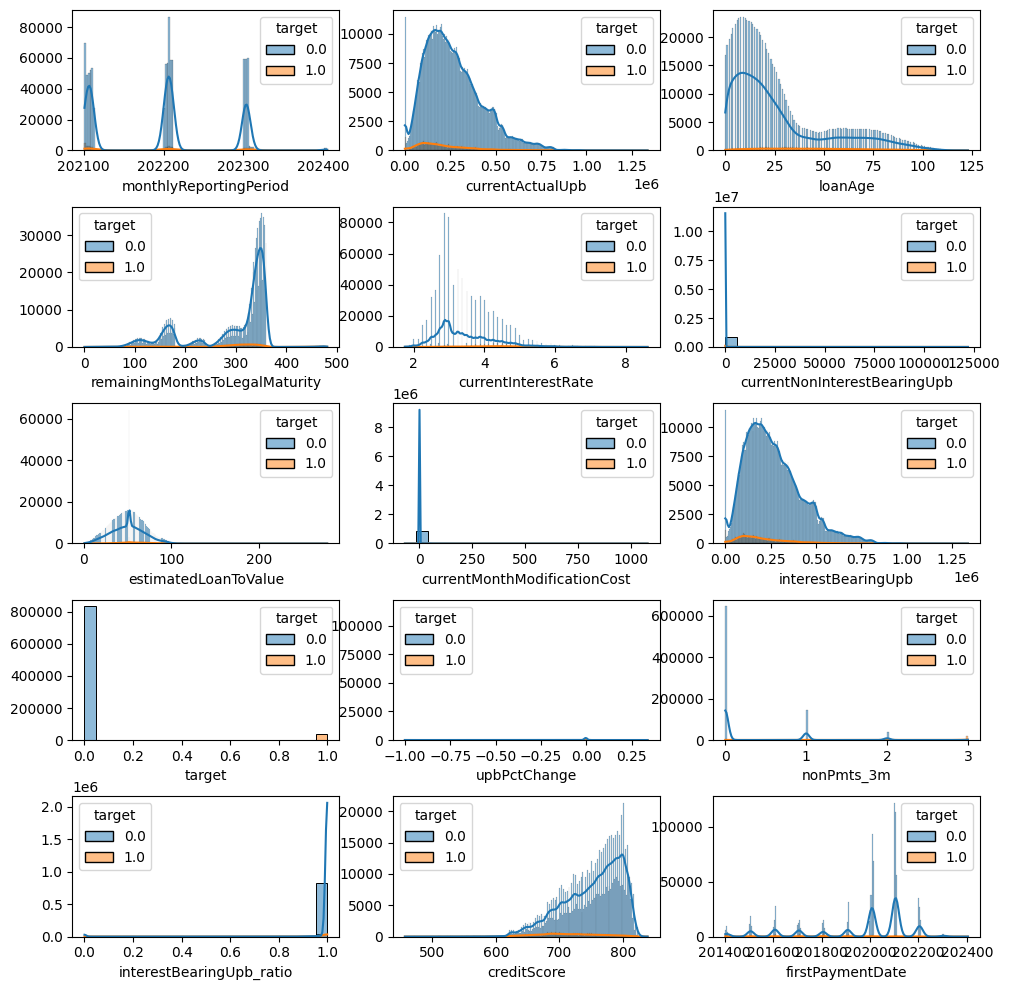

In [36]:
numeric_cols = train.select_dtypes(include='number').columns

def vis_features_hist(df, cate_cols, first):
    last = first + 15
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))
    for i, column in enumerate(df.columns[first:last]):
        ax = axes[i // 3, i % 3]
        if column in cate_cols:
            sns.countplot(data=df, x=column, ax=axes[i//3, i%3])  #row, column
        else:
            sns.histplot(data=df, x=column, hue='target', kde=True, ax=axes[i//3, i%3])
        ax.set_ylabel('')  # Remove y-axis label

    for j in range(i + 1, 15):
        fig.delaxes(axes[j//3, j%3])  #delete empty subplots
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.4)  # reduce space between subplots
    plt.show()
    
vis_features_hist(train[numeric_cols], [], 0)

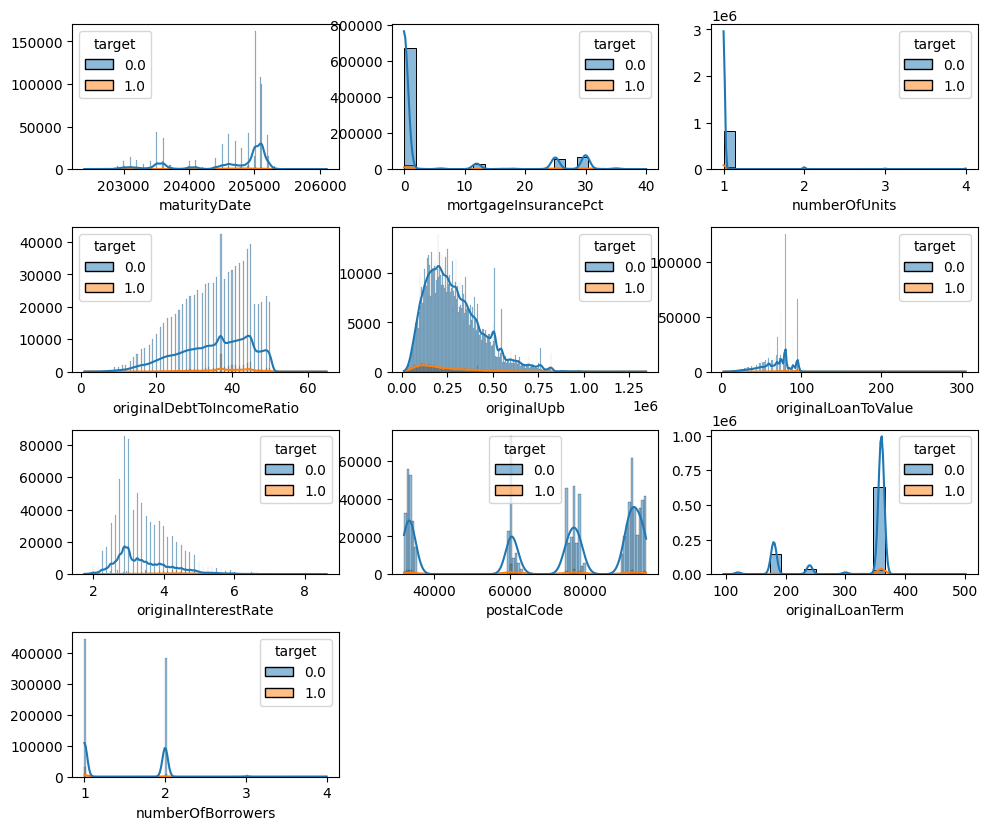

In [37]:
vis_features_hist(train[numeric_cols], [], 15)

In [38]:
train = train.loc[train['interestBearingUpb_ratio'] > 0.4]

In [ ]:
# currentActualUpb, remove outliers
train = train.loc[train['currentActualUpb'] < 1250000] 

In [40]:
train.isnull().sum()

loanSequenceNumber                0
monthlyReportingPeriod            0
currentActualUpb                  0
currentLoanDelinquencyStatus      0
loanAge                           0
remainingMonthsToLegalMaturity    0
modificationFlag                  0
currentInterestRate               0
currentNonInterestBearingUpb      0
stepModificationFlag              0
paymentDeferral                   0
estimatedLoanToValue              0
delinquencyDueToDisaster          0
borrowerAssistanceStatusCode      0
currentMonthModificationCost      0
interestBearingUpb                0
target                            0
upbPctChange                      0
nonPmts_3m                        0
delinquencyDueToDisaster_hist     0
interestBearingUpb_ratio          0
creditScore                       0
firstPaymentDate                  0
firstTimeHomebuyerFlag            0
maturityDate                      0
mortgageInsurancePct              0
numberOfUnits                     0
occupancyStatus             

In [41]:
# save the cleaned dataset
train.to_pickle("./data/010_train_cleaned.pkl")

#### WoE coding

In [42]:
train = pd.read_pickle("./data/010_train_cleaned.pkl")
train.isnull().any()

loanSequenceNumber                False
monthlyReportingPeriod            False
currentActualUpb                  False
currentLoanDelinquencyStatus      False
loanAge                           False
remainingMonthsToLegalMaturity    False
modificationFlag                  False
currentInterestRate               False
currentNonInterestBearingUpb      False
stepModificationFlag              False
paymentDeferral                   False
estimatedLoanToValue              False
delinquencyDueToDisaster          False
borrowerAssistanceStatusCode      False
currentMonthModificationCost      False
interestBearingUpb                False
target                            False
upbPctChange                      False
nonPmts_3m                        False
delinquencyDueToDisaster_hist     False
interestBearingUpb_ratio          False
creditScore                       False
firstPaymentDate                  False
firstTimeHomebuyerFlag            False
maturityDate                      False


In [43]:
train = train.drop(columns=['loanSequenceNumber', 'monthlyReportingPeriod'])

In [44]:
# for binning to work well
train['target'] = train['target'].astype(int)

# Convert object (string) and category type columns to string
for col in train.select_dtypes(include=['object', 'category']).columns:
    train[col] = train[col].astype(str)

In [45]:
'''
bins = sc.woebin(train,
                 y = 'target',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree')

sc.woebin_plot(bins)
plt.show()
'''

"\nbins = sc.woebin(train,\n                 y = 'target',\n                 min_perc_fine_bin=0.02, # How many bins to cut initially into\n                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin\n                 stop_limit=0.02, # Minimum information value\n                 max_num_bin=8, # Maximum number of bins\n                 method='tree')\n\nsc.woebin_plot(bins)\nplt.show()\n"

##### information value filtering and mannual adjustment

In [46]:
# these are below 0.02
vars = [
    'delinquencyDueToDisaster_hist', 
    'superConformingFlag',
    'programIndicator',
    'channel',
    'currentMonthModificationCost',
    'interestBearingUpb_ratio',
    'reliefRefinanceIndicator',
    'paymentDeferral',
    'stepModificationFlag',
    'modificationFlag',
    'numberOfUnits',
    'borrowerAssistanceStatusCode',
    'currentNonInterestBearingUpb',
    'delinquencyDueToDisaster',
    'currentLoanDelinquencyStatus'
    ]
train = train.drop(columns=vars)

# these only have 1 unique value
vars= [
    'prepaymentPenaltyMortgageFlag',
    'amortizationType',
    'interestOnlyIndicator'
]
train = train.drop(columns=vars)

In [47]:
# rerun 
bins = sc.woebin(train,
                 y = 'target',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree'
                 )

[INFO] creating woe binning ...


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/condition_fun.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/condition_fun.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/condition_fun.py:25: UserWarning: Could not infer format, so each element will be parsed individually, 

Binning on 861593 rows and 27 columns in 00:00:34


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:1225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


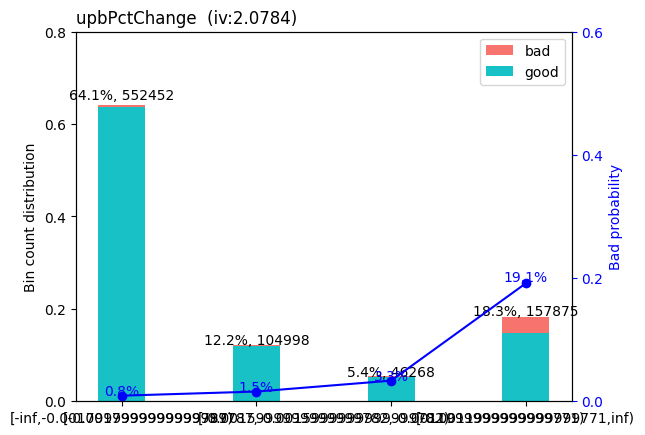

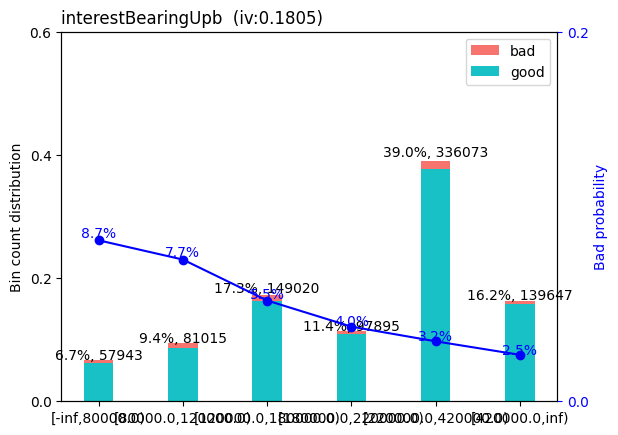

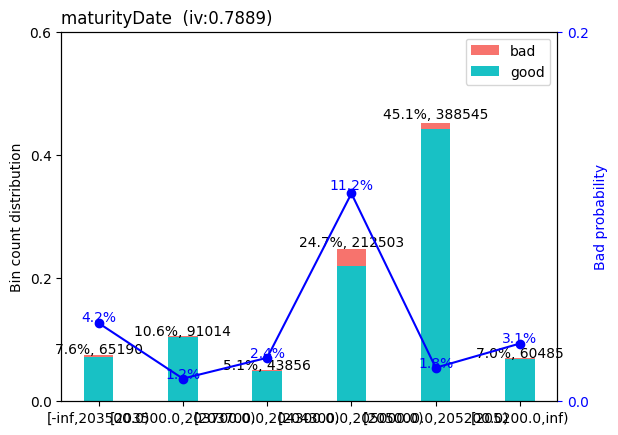

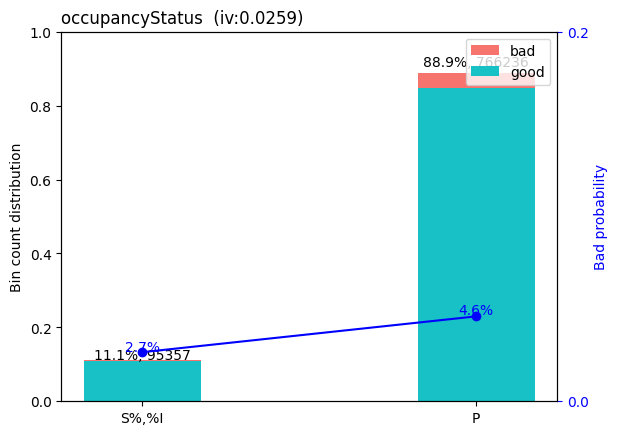

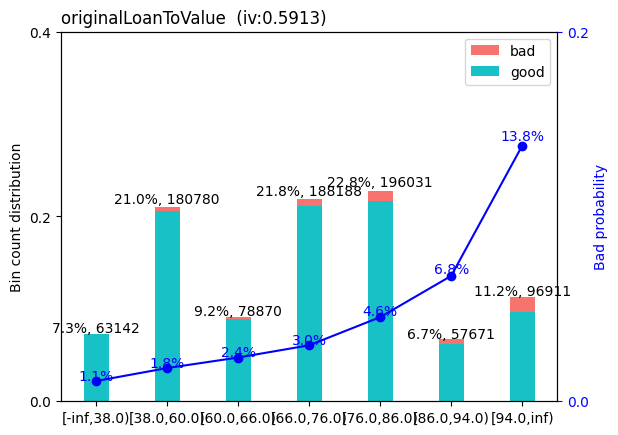

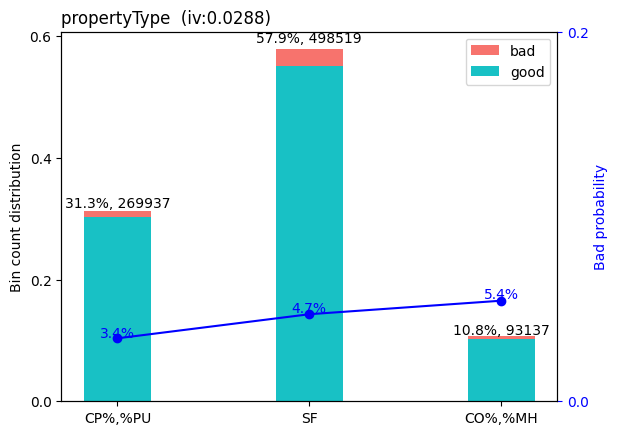

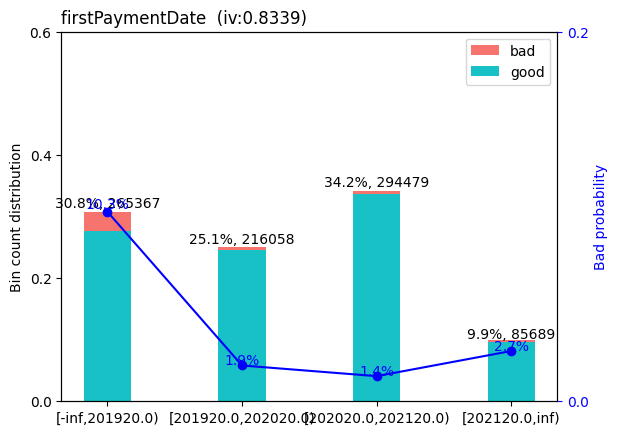

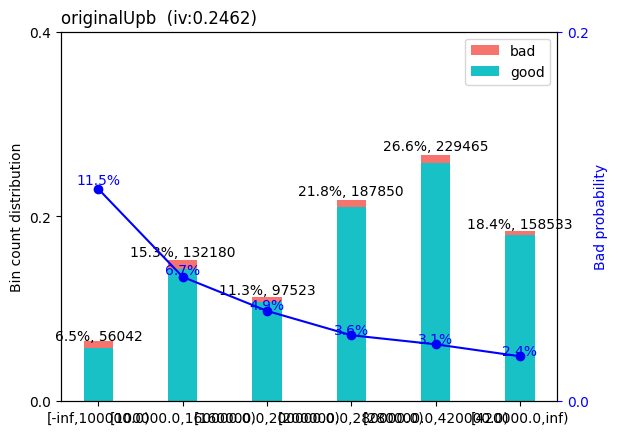

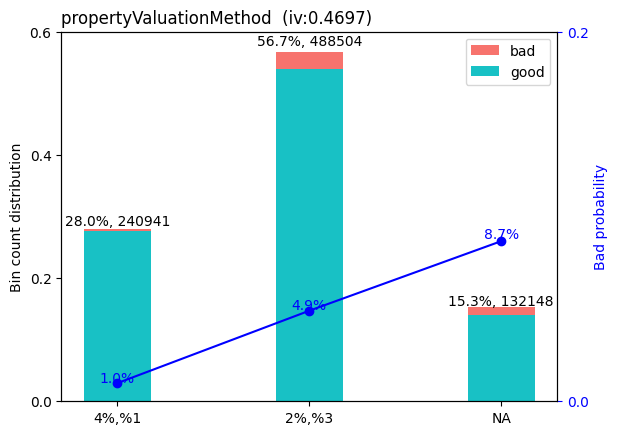

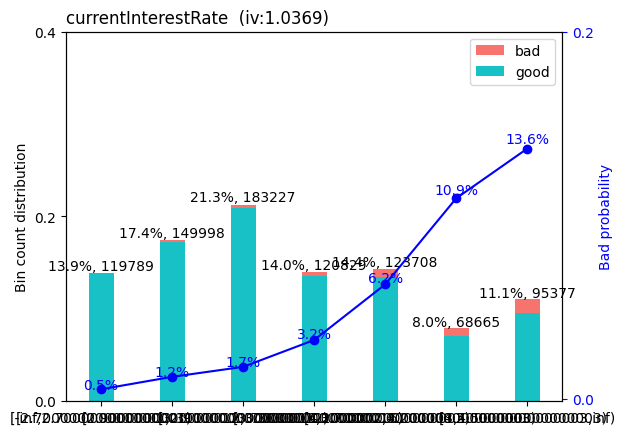

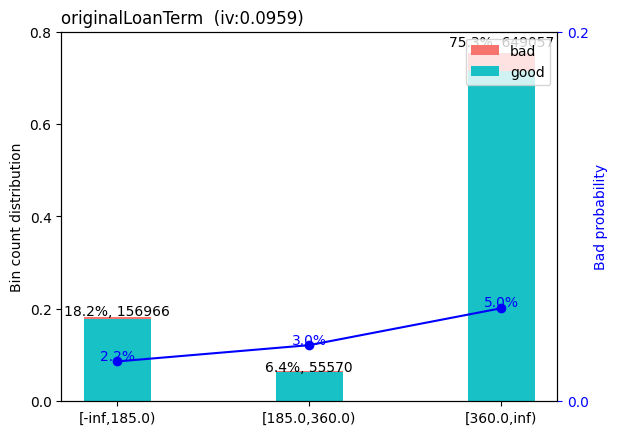

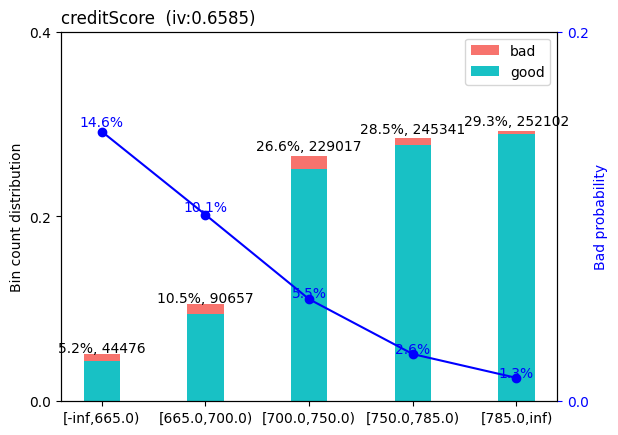

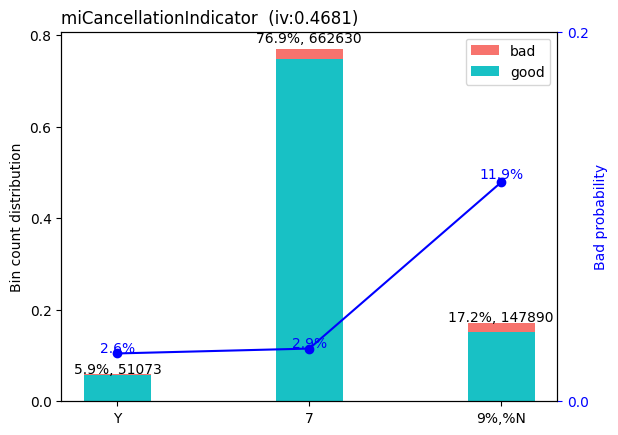

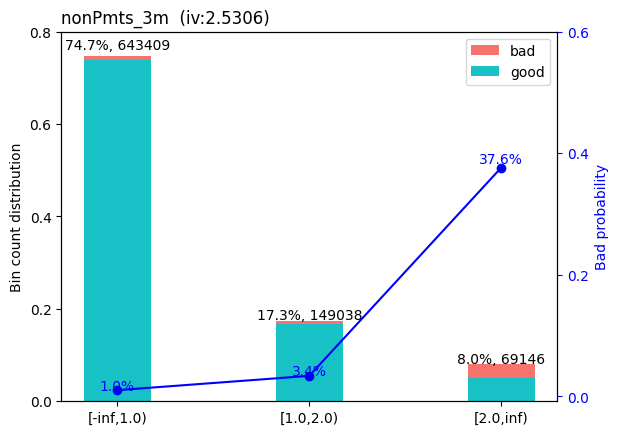

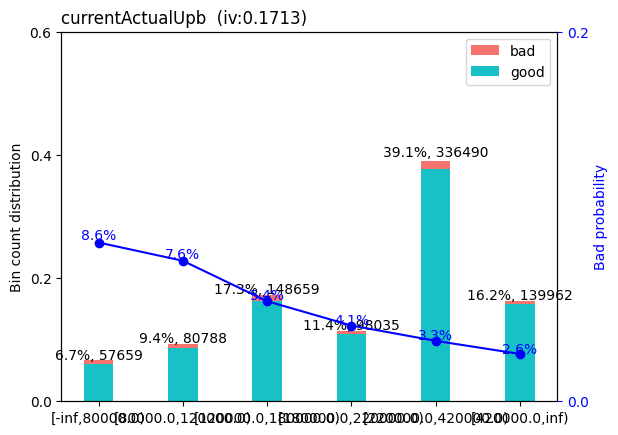

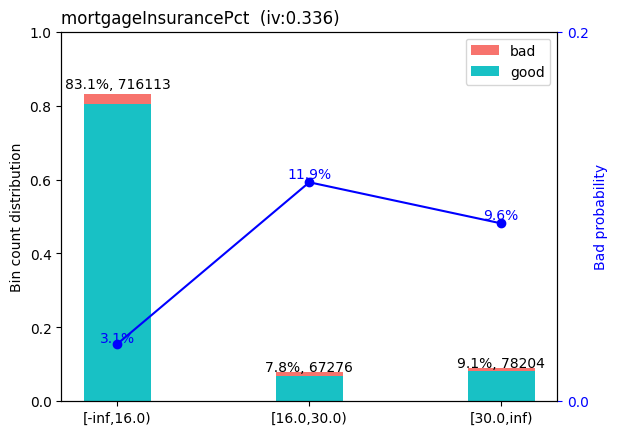

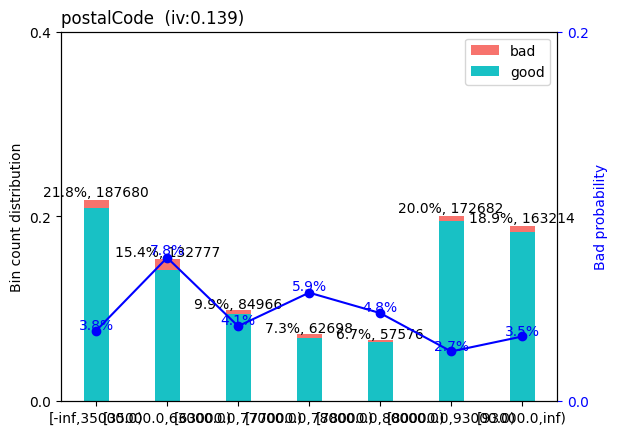

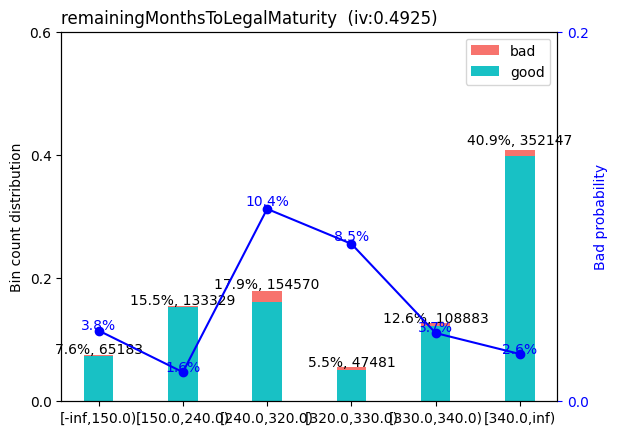

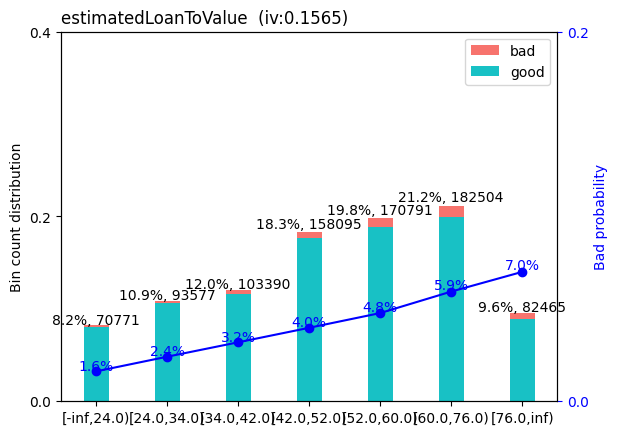

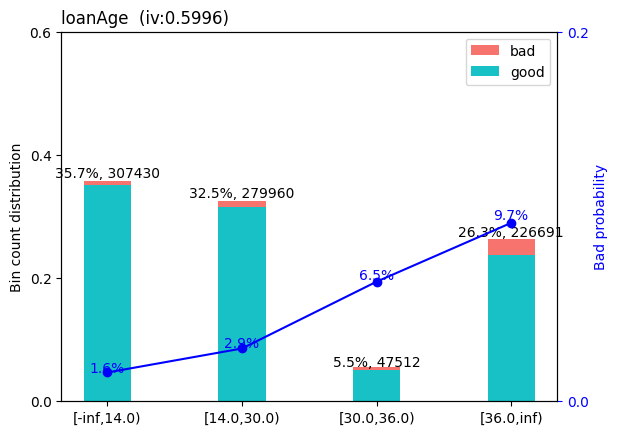

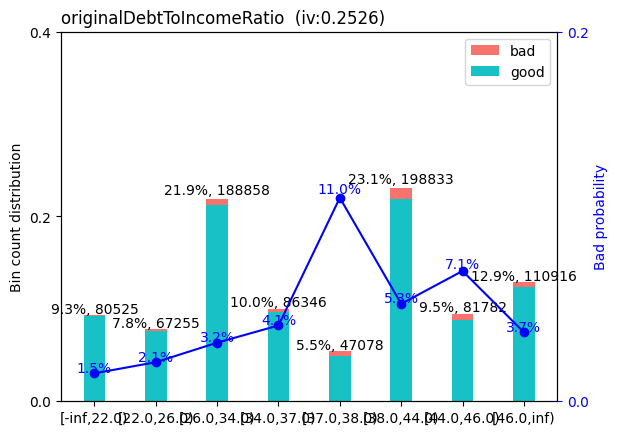

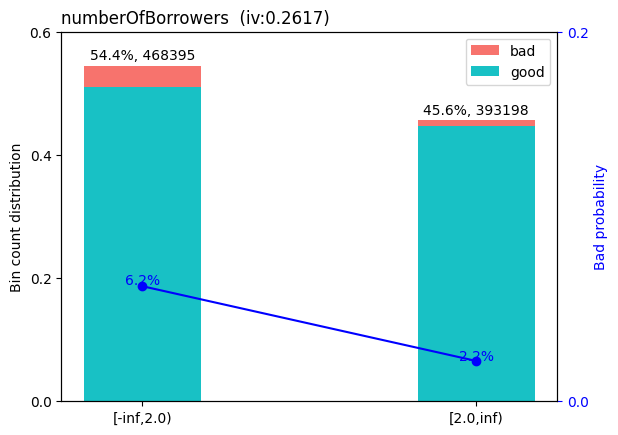

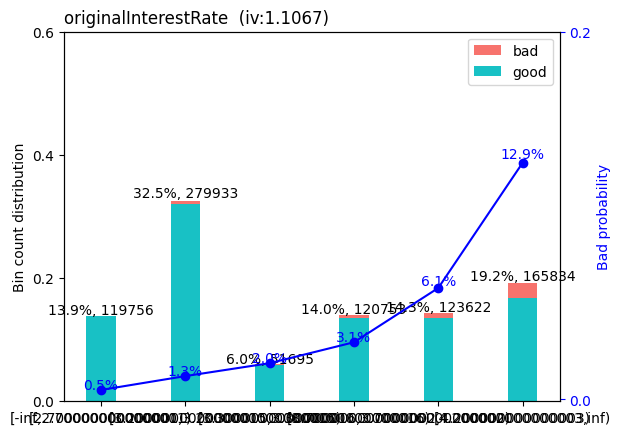

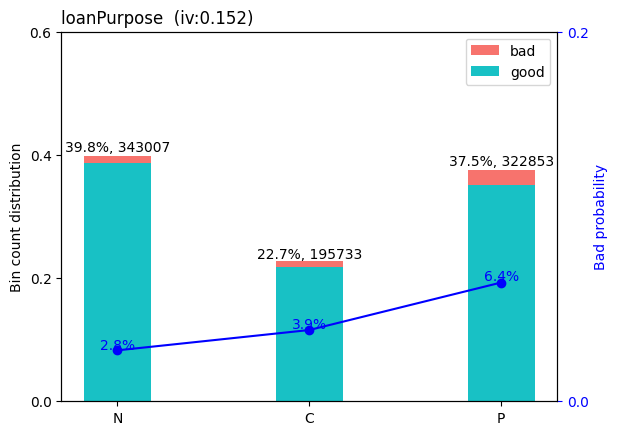

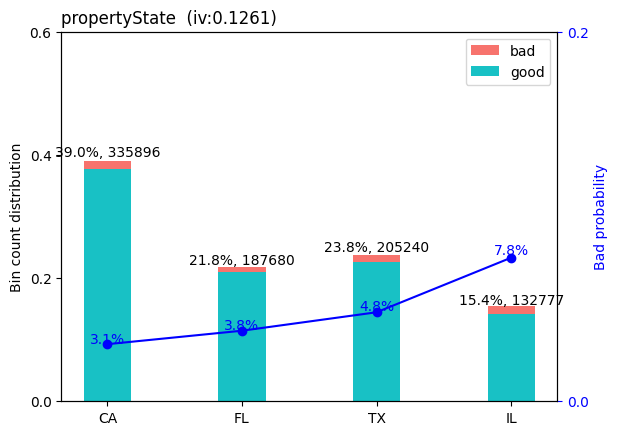

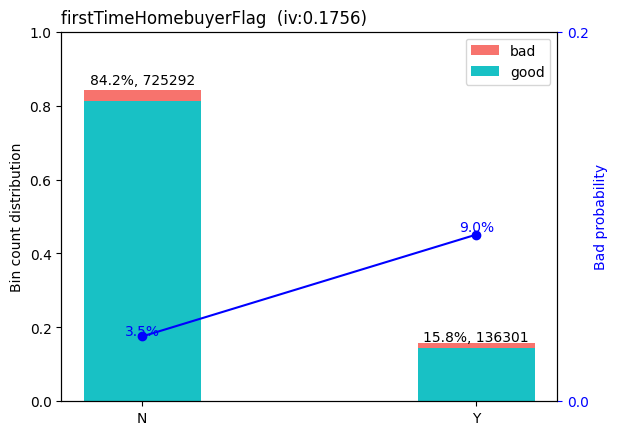

In [48]:
sc.woebin_plot(bins)
plt.show()

In [49]:
# adjust bins for originalDebtToIncomeRatio
custom_breaks = {'originalDebtToIncomeRatio': [26, 34, 44]}     
bins = sc.woebin(train, y='target', 
                 breaks_list=custom_breaks)

[INFO] creating woe binning ...


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/condition_fun.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/condition_fun.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/condition_fun.py:25: UserWarning: Could not infer format, so each element will be parsed individually, 

Binning on 861593 rows and 27 columns in 00:00:32


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

In [50]:
bins.get('originalDebtToIncomeRatio')

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,originalDebtToIncomeRatio,"[-inf,26.0)",147780,0.171519,145139,2641,0.017871,-0.923512,0.098087,0.16384,26.0,False
1,originalDebtToIncomeRatio,"[26.0,34.0)",188858,0.219196,182869,5989,0.031712,-0.335823,0.021263,0.16384,34.0,False
2,originalDebtToIncomeRatio,"[34.0,44.0)",332257,0.385631,313046,19211,0.057820,0.292155,0.037668,0.16384,44.0,False
3,originalDebtToIncomeRatio,"[44.0,inf)",192698,0.223653,182790,9908,0.051417,0.168027,0.006821,0.16384,inf,False


In [51]:
bins['creditScore'][['bin', 'count', 'badprob', 'woe']]

,bin,count,badprob,woe
0,"[-inf,700.0)",135133,0.115753,1.049741
1,"[700.0,750.0)",229017,0.055236,0.243703
2,"[750.0,785.0)",245341,0.025544,-0.558453
3,"[785.0,inf)",252102,0.012654,-1.274056


above shows the higher creditScore corresponds to lower WOE values, therefore the estimated linear model coefficient of creditScore should be interpreted in reverse. That is, if creditScore is correctly WOE transformed, we would expect a coeeficeint estimate to be $ - \hat{\beta}$

In [52]:
# Loop other binned variables to detect this problem
for var, df in bins.items():
    print(f"Variable: {var}")
    print(df[['bin', 'count', 'badprob', 'woe']])
    print("\n")

Variable: upbPctChange
                                               bin   count   badprob       woe
0                    [-inf,-0.0017999999999999787)  552452  0.008250 -1.706176
1  [-0.0017999999999999787,-0.0011999999999999771)  151266  0.020355 -0.790848
2                     [-0.0011999999999999771,inf)  157875  0.190733  1.637769


Variable: interestBearingUpb
                   bin   count   badprob       woe
0      [-inf,120000.0)  138958  0.081032  0.654611
1  [120000.0,180000.0)  149020  0.054516  0.229823
2  [180000.0,420000.0)  433968  0.034233 -0.256712
3       [420000.0,inf)  139647  0.025128 -0.575316


Variable: maturityDate
                   bin   count   badprob       woe
0      [-inf,203500.0)   65190  0.042322 -0.036171
1  [203500.0,204300.0)  134870  0.015926 -1.040697
2  [204300.0,205000.0)  212503  0.112455  1.017115
3       [205000.0,inf)  449030  0.019921 -0.812851


Variable: occupancyStatus
     bin   count   badprob       woe
0  S%,%I   95357  0.026563 -0.

##### apply the bins to the training set 

In [53]:
train_woe = sc.woebin_ply(train, bins)

[INFO] converting into woe values ...
Woe transformating on 861593 rows and 26 columns in 00:00:26


In [54]:
train_woe.head()

,target,upbPctChange_woe,maturityDate_woe,occupancyStatus_woe,originalLoanToValue_woe,propertyType_woe,propertyValuationMethod_woe,nonPmts_3m_woe,estimatedLoanToValue_woe,loanAge_woe,...,originalLoanTerm_woe,creditScore_woe,miCancellationIndicator_woe,currentActualUpb_woe,mortgageInsurancePct_woe,postalCode_woe,remainingMonthsToLegalMaturity_woe,loanPurpose_woe,propertyState_woe,firstTimeHomebuyerFlag_woe
0,0,1.637769,1.017115,0.050082,-0.146579,-0.261624,0.727529,-1.474355,0.002212,0.781824,...,0.14583,0.243703,1.076377,-0.246671,-0.357003,-0.232034,0.881992,-0.480342,-0.362608,-0.230913
1,0,-1.706176,1.017115,0.050082,-0.146579,-0.261624,0.727529,-1.474355,0.002212,0.781824,...,0.14583,0.243703,1.076377,-0.246671,-0.357003,-0.232034,0.881992,-0.480342,-0.362608,-0.230913
2,0,-1.706176,1.017115,0.050082,-0.146579,-0.261624,0.727529,-1.474355,0.002212,0.781824,...,0.14583,0.243703,1.076377,-0.246671,-0.357003,-0.232034,0.881992,-0.480342,-0.362608,-0.230913
5,0,-1.706176,1.017115,0.050082,-0.146579,-0.261624,0.727529,-1.474355,-0.329125,0.781824,...,0.14583,0.243703,1.076377,-0.246671,-0.357003,-0.232034,0.881992,-0.480342,-0.362608,-0.230913
6,0,-1.706176,1.017115,0.050082,-0.146579,-0.261624,0.727529,-1.474355,-0.329125,0.781824,...,0.14583,0.243703,1.076377,-0.246671,-0.357003,-0.232034,0.881992,-0.480342,-0.362608,-0.230913


In [55]:
# save the bins
import pickle
with open('./data/010_bins.pkl', 'wb') as f:
	pickle.dump(bins, f)

##### correlation analysis

<Axes: >

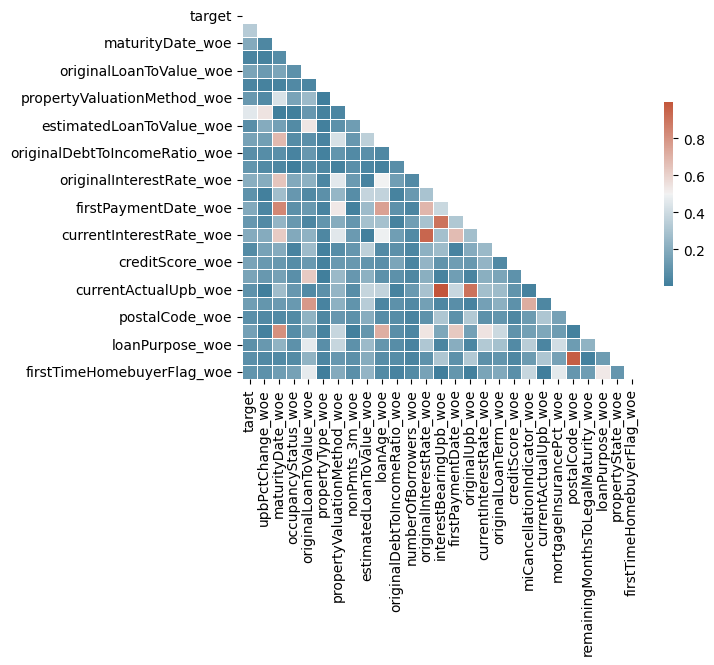

In [56]:
# correlation matrix
corr = train_woe.corr()
corr = np.abs(corr)

# mask upper triangle of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# color map
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
            linewidths=0.5, cbar_kws={"shrink": .5})

remove these: interetsBearingUpb, postalCode, originalInterestRate

In [57]:
train_woe = train_woe.drop(columns=['interestBearingUpb_woe',
                        'postalCode_woe', 'originalInterestRate_woe'])

In [58]:
train_woe.to_pickle("./data/010_train_woe.pkl")

In [59]:
train_woe.columns  # 24 columns including target

Index(['target', 'upbPctChange_woe', 'maturityDate_woe', 'occupancyStatus_woe',
       'originalLoanToValue_woe', 'propertyType_woe',
       'propertyValuationMethod_woe', 'nonPmts_3m_woe',
       'estimatedLoanToValue_woe', 'loanAge_woe',
       'originalDebtToIncomeRatio_woe', 'numberOfBorrowers_woe',
       'firstPaymentDate_woe', 'originalUpb_woe', 'currentInterestRate_woe',
       'originalLoanTerm_woe', 'creditScore_woe',
       'miCancellationIndicator_woe', 'currentActualUpb_woe',
       'mortgageInsurancePct_woe', 'remainingMonthsToLegalMaturity_woe',
       'loanPurpose_woe', 'propertyState_woe', 'firstTimeHomebuyerFlag_woe'],
      dtype='object')